In [ ]:
import pandas as pd
import re
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Load the dataset

In [ ]:
file_path = '7817_1.csv'
data = pd.read_csv(file_path)

In [ ]:
data.head(), data.columns

(                     id       asins   brand                  categories  \
 0  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
 1  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
 2  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
 3  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
 4  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
 
   colors             dateAdded           dateUpdated  \
 0    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
 1    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
 2    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
 3    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
 4    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
 
                   dimension  ean                         keys  ...  \
 0  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00qjdu3ky  ...   
 1  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00q

In [ ]:
data['reviews.text']

0       I initially had trouble deciding between the p...
1       Allow me to preface this with a little history...
2       I am enjoying it so far. Great for reading. Ha...
3       I bought one of the first Paperwhites and have...
4       I have to say upfront - I don't like coroporat...
                              ...                        
1592    This is not the same remote that I got for my ...
1593    I have had to change the batteries in this rem...
1594    Remote did not activate, nor did it connect to...
1595    It does the job but is super over priced. I fe...
1596    I ordered this item to replace the one that no...
Name: reviews.text, Length: 1597, dtype: object

# Data Preprocessing

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
reviews = data["reviews.text"].dropna().values

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"\b\w{1,2}\b", "", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = " ".join([word for word in text.split() if word not in stopwords.words("english")])
    return text

In [ ]:
processed_reviews = [preprocess_text(review) for review in reviews]
processed_reviews[:5]

['initially trouble deciding paperwhite voyage reviews less said thing paperwhite great spending money voyagefortunately friends owned ended buying paperwhite basis models ppi dollar jump turns pricey voyage page press always sensitive fine specific setting need auto light adjustment week loving paperwhite regrets touch screen receptive easy use keep light specific setting regardless time day case hard change setting either changing light level certain time day every readingalso glad went international shipping option amazon extra expense delivery time tracking didnt need worry customs may used third party shipping service',
 'allow preface little history casual reader owned nook simple touch read harry potter series girl dragon tattoo series brave new world key titles fair say nook get much use many others may gotten theirsfast forward today full week new kindle paperwhite admit love kindle reading let relate review love reading back kindle investment experience receive buy kindle sim

# LDA

In [ ]:
count_vectorizer = CountVectorizer(max_df=0.9, min_df=10, max_features=1000)
count_data = count_vectorizer.fit_transform(processed_reviews)

lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda_model.fit_transform(count_data)

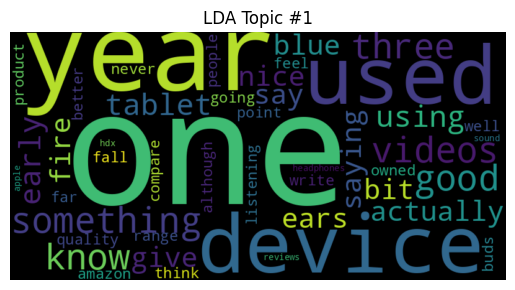

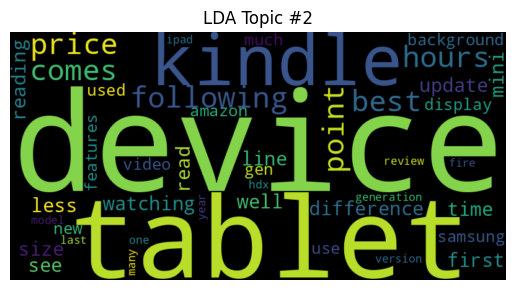

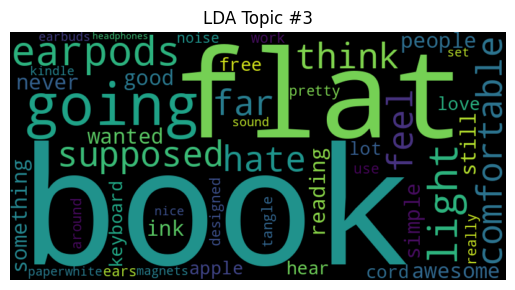

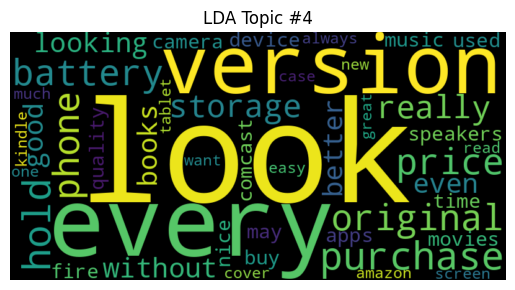

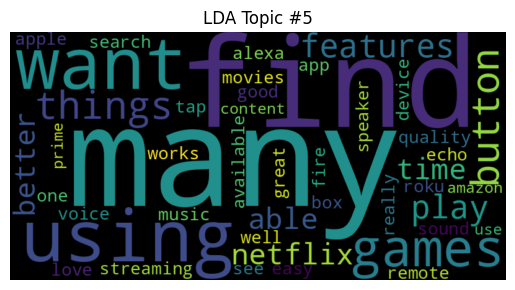

In [ ]:
for idx, topic in enumerate(lda_model.components_):
    wordcloud = WordCloud(width=800, height=400, max_words=50).generate(" ".join(
        [count_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-50:]]
    ))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"LDA Topic #{idx + 1}")
    plt.axis("off")
    plt.show()

# NMF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=10, max_features=1000)
tfidf_data = tfidf_vectorizer.fit_transform(processed_reviews)

nmf_model = NMF(n_components=5, random_state=42)
nmf_topics = nmf_model.fit_transform(tfidf_data)

In [ ]:
print("NMF Topics:")
for idx, topic in enumerate(nmf_model.components_):
    print(f"Topic #{idx + 1}:")
    print(" ".join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]))
    print("\n")


NMF Topics:
Topic #1:
last screen device new year hdx ipad tablet fire kindle


Topic #2:
ears owned write range people sound reviews buds apple headphones


Topic #3:
dot music portable sound love alexa speaker great echo tap


Topic #4:
nice set designed like tangle noise ears magnets earbuds headphones


Topic #5:
box available want roku comcast remote amazon content movies prime




In [ ]:
nmf_topics = {
    "Topic 1": "last screen device new year hdx ipad tablet fire kindle",
    "Topic 2": "ears owned write range people sound reviews buds apple headphones",
    "Topic 3": "dot music portable sound love alexa speaker great echo tap",
    "Topic 4": "nice set designed like tangle noise ears magnets earbuds headphones",
    "Topic 5": "box available want roku comcast remote amazon content movies prime"
}
model_name = "NMF"

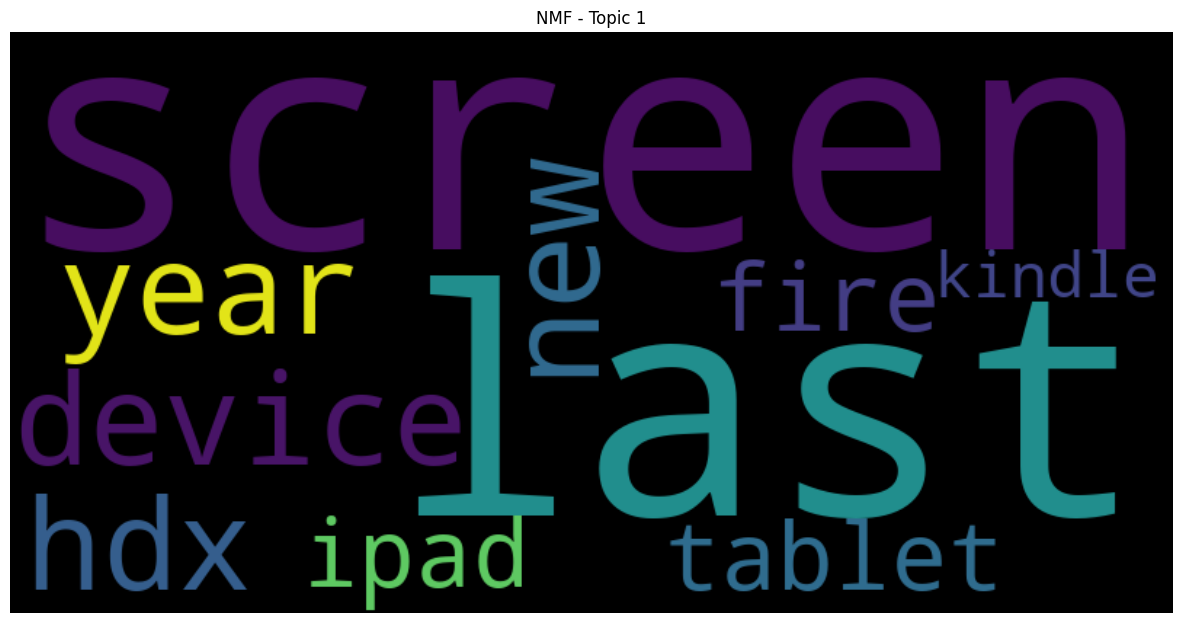

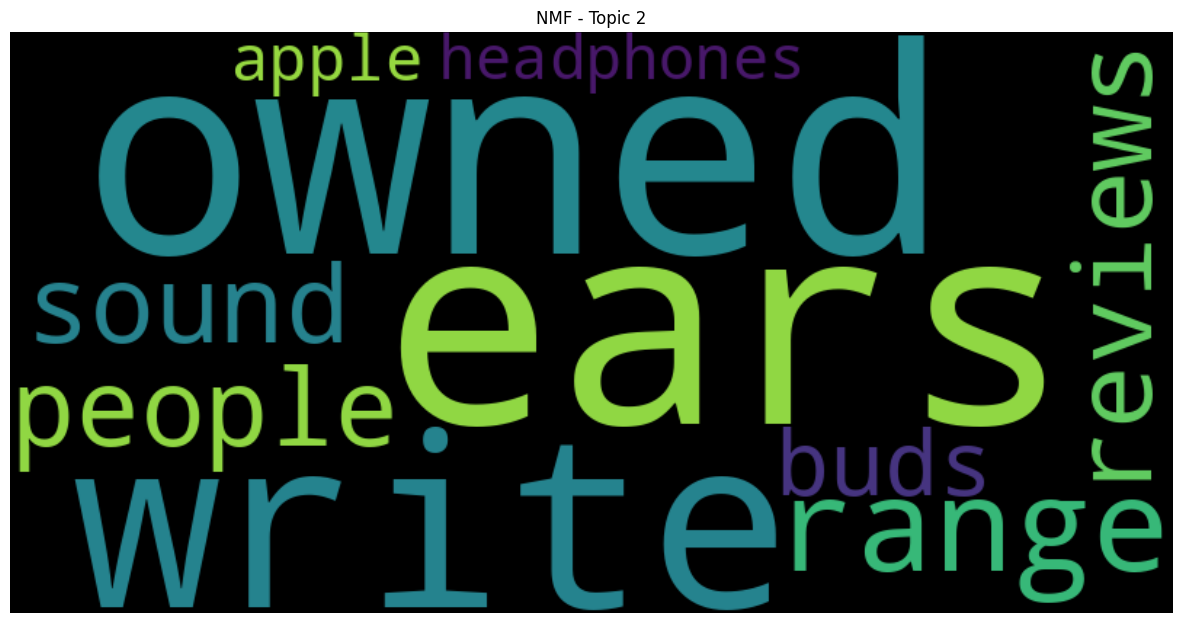

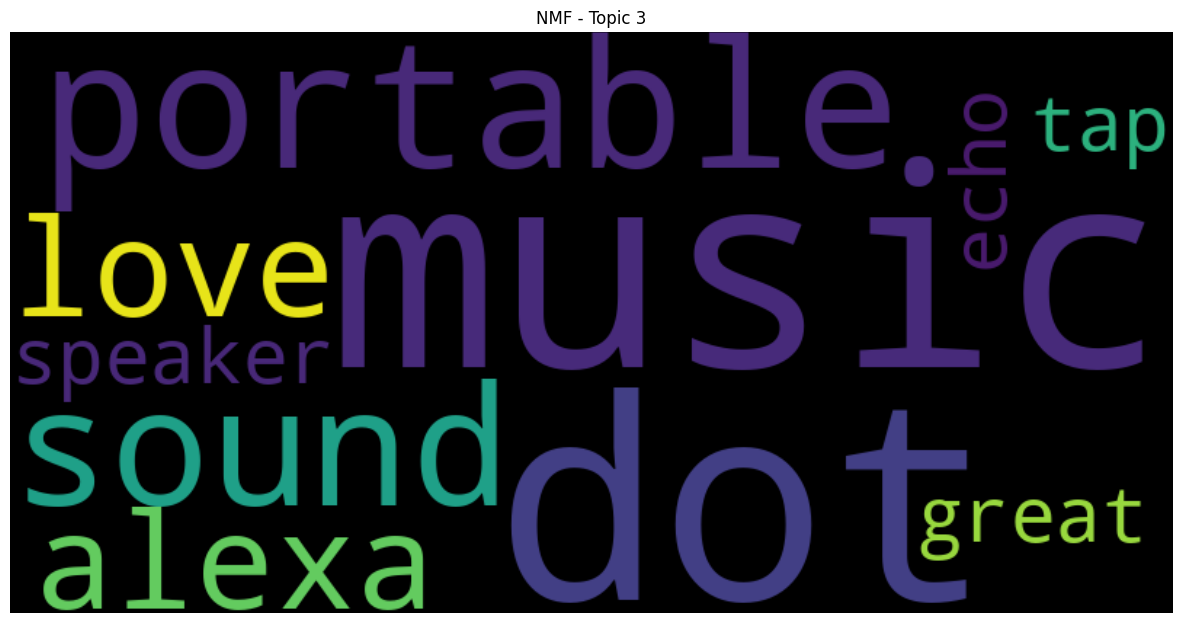

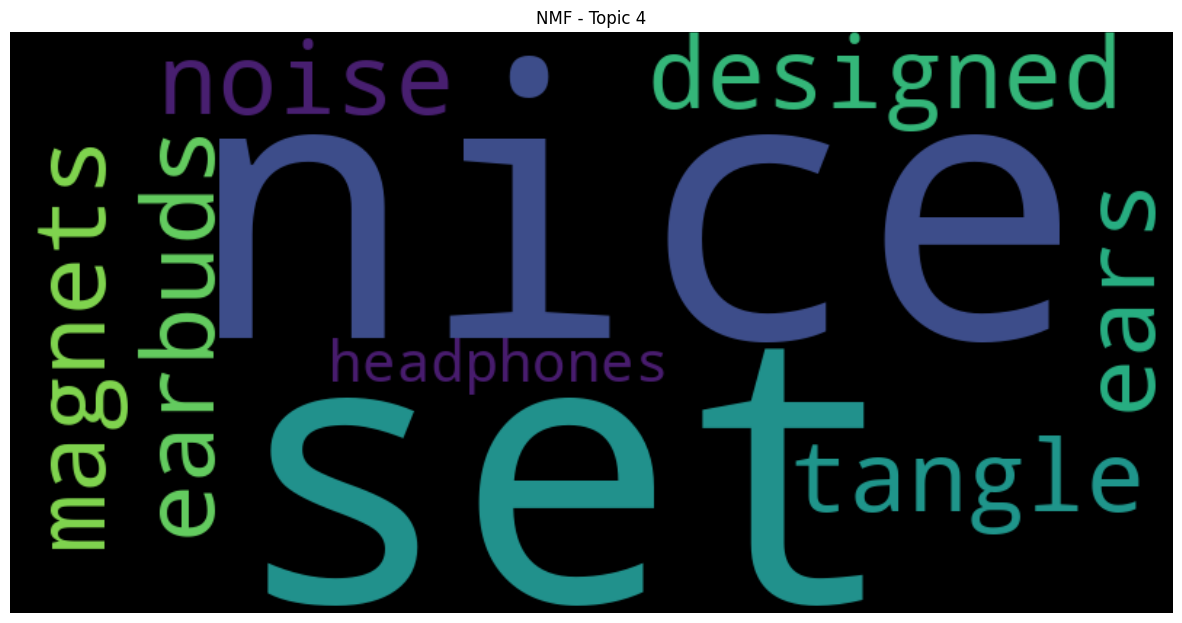

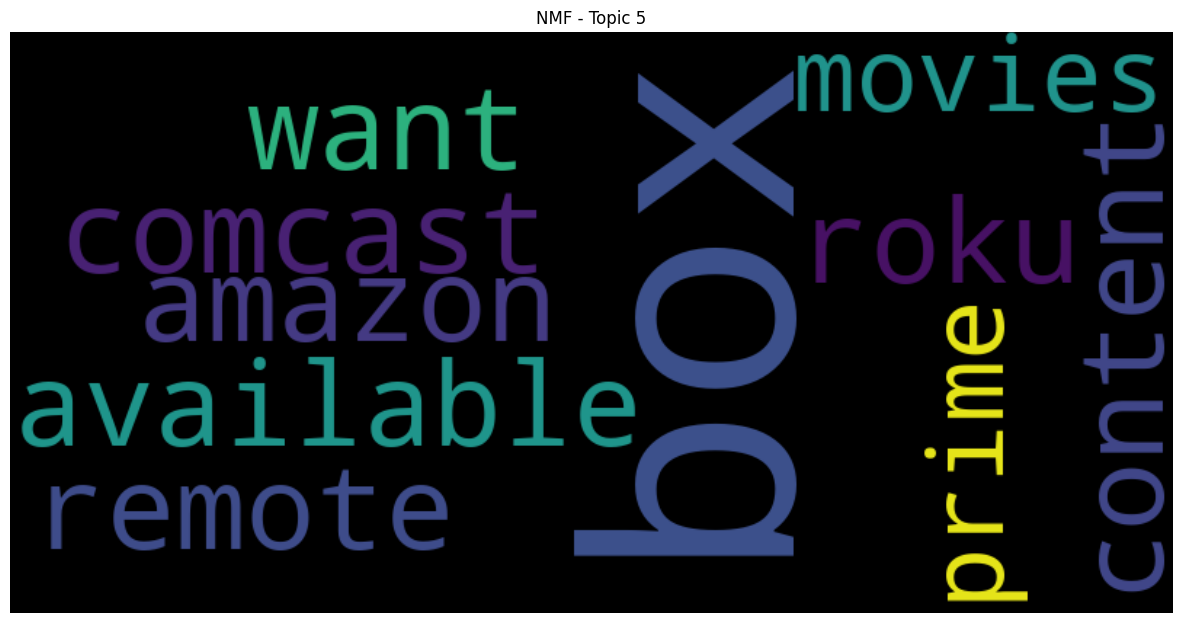

In [ ]:
for i, (topic, words) in enumerate(nmf_topics.items(), 1):
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(words)
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"NMF - {topic}")
    plt.axis('off')
    plt.show()

# LSA

In [ ]:
lsa_model = TruncatedSVD(n_components=5, random_state=42)
lsa_topics = lsa_model.fit_transform(tfidf_data)

In [ ]:
print("LSA Topics:")
for idx, topic in enumerate(lsa_model.components_):
    print(f"Topic #{idx + 1}:")
    print(" ".join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]))
    print("\n")

LSA Topics:
Topic #1:
one apple use great sound like amazon fire headphones kindle


Topic #2:
fall reviews magnets earbuds people buds sound apple ears headphones


Topic #3:
bluetooth dot music portable love great alexa speaker echo tap


Topic #4:
supposed flat cancelling set designed tangle noise headphones earbuds magnets


Topic #5:
box apple amazon available roku remote comcast content movies prime




In [ ]:
lsa_topics = {
    "Topic 1": "one apple use great sound like amazon fire headphones kindle",
    "Topic 2": "fall reviews magnets earbuds people buds sound apple ears headphones",
    "Topic 3": "bluetooth dot music portable love great alexa speaker echo tap",
    "Topic 4": "supposed flat cancelling set designed tangle noise headphones earbuds magnets",
    "Topic 5": "box apple amazon available roku remote comcast content movies prime"
}
model_name = "LSA"

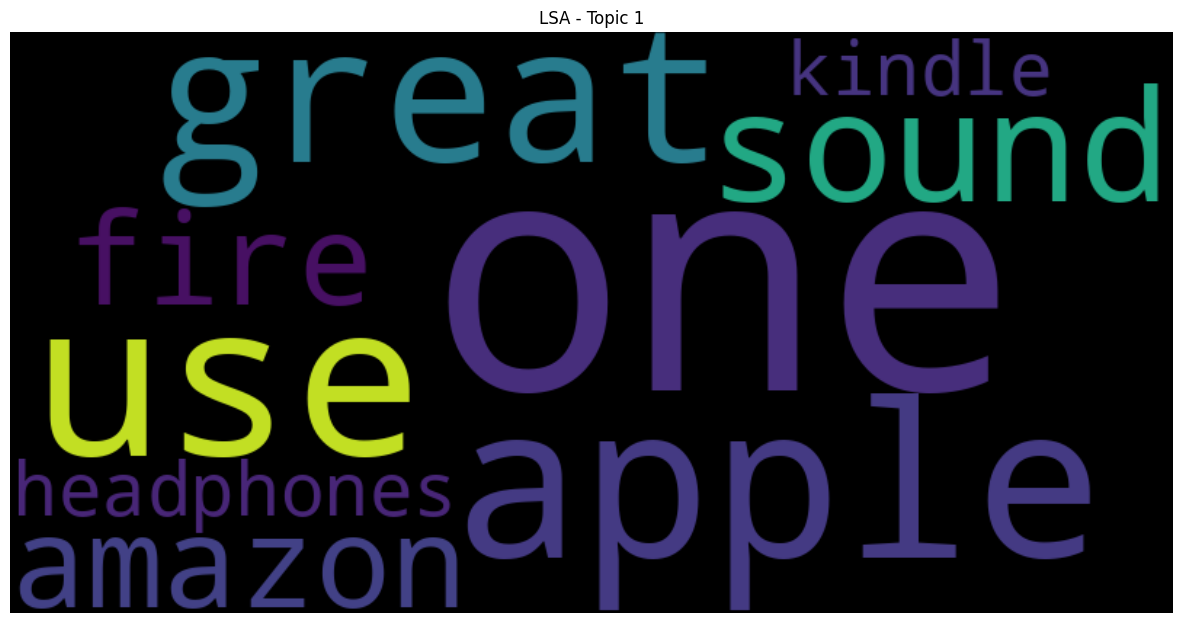

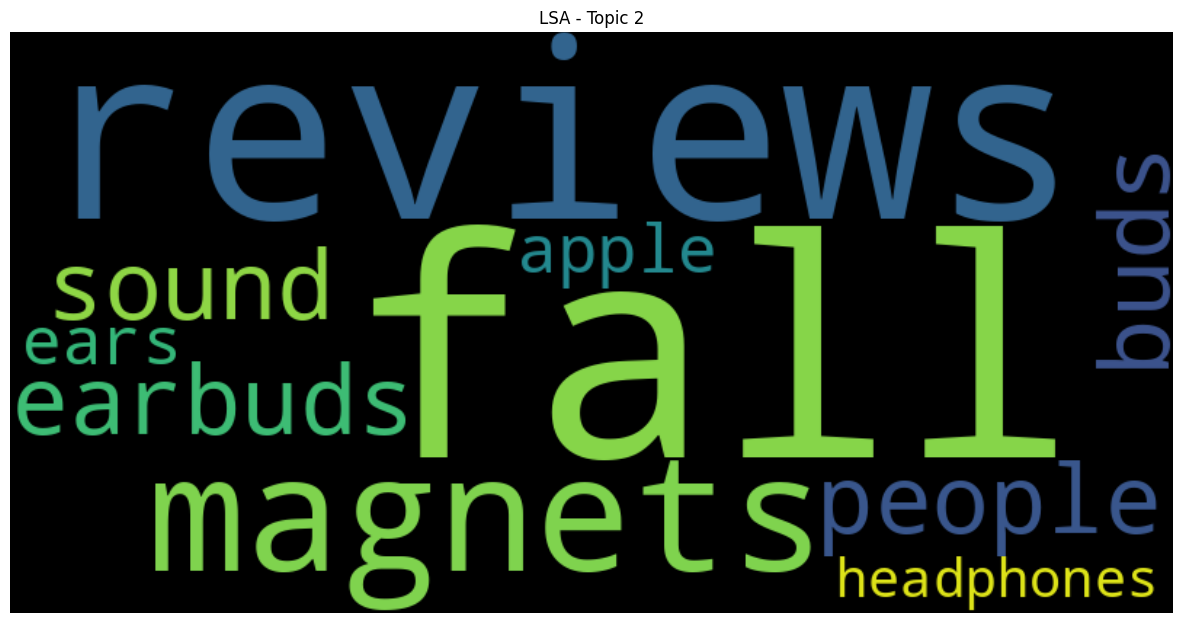

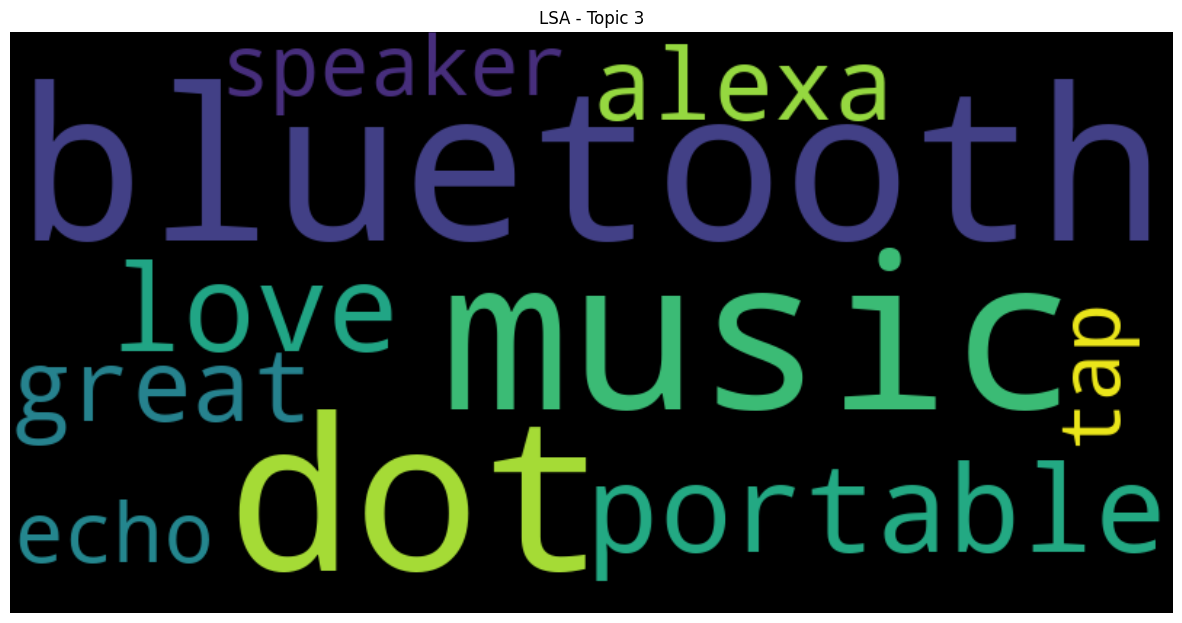

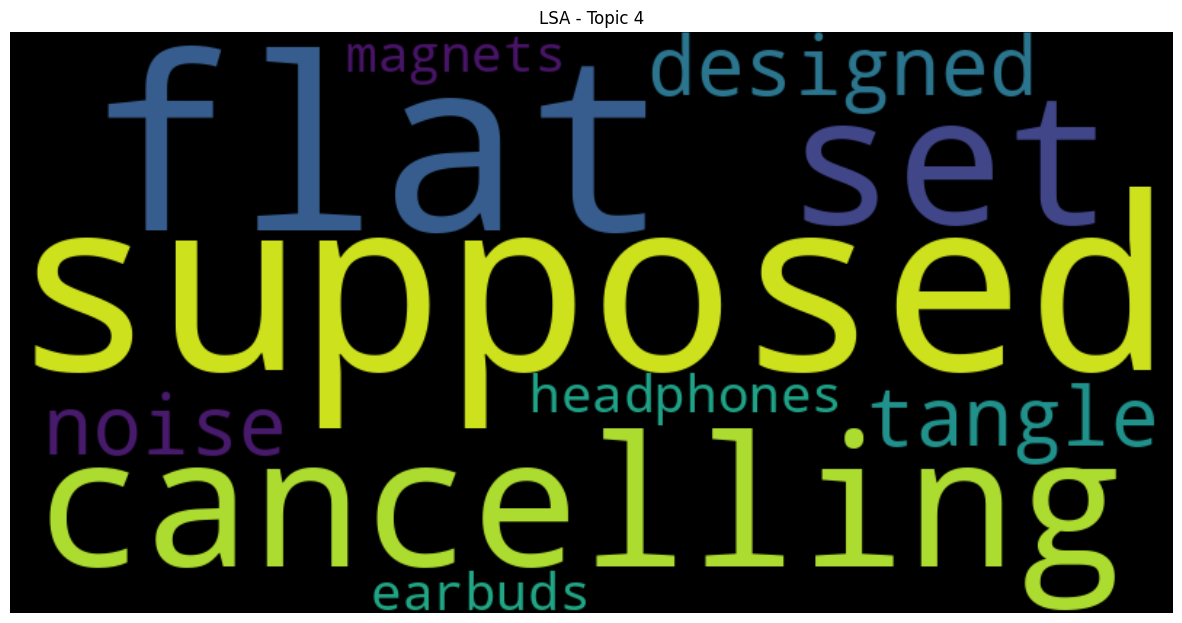

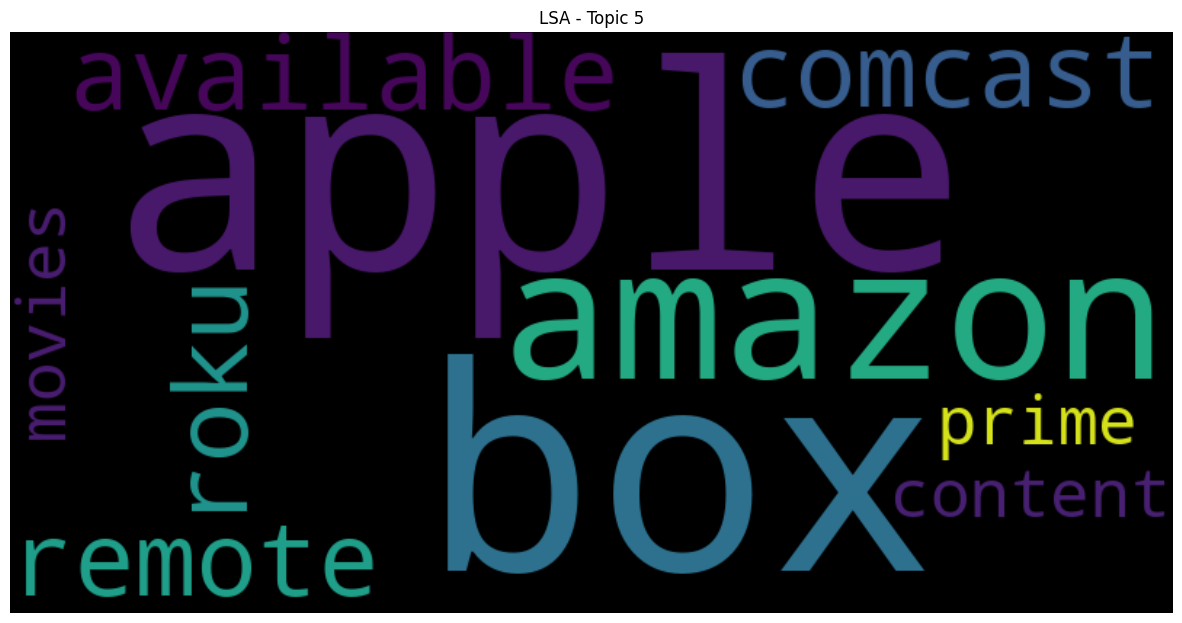

In [ ]:
for i, (topic, words) in enumerate(lsa_topics.items(), 1):
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(words)
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"LSA - {topic}")
    plt.axis('off')
    plt.show()

# BERT

In [ ]:
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = bert_model.encode(processed_reviews)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
num_topics = 5
kmeans = KMeans(n_clusters=num_topics, random_state=42)
kmeans.fit(embeddings)

KMeans(n_clusters=5, random_state=42)

In [ ]:
print("BERT-Based Topics:")
for i in range(num_topics):
    print(f"Topic #{i + 1}:")
    topic_reviews = [processed_reviews[j] for j in range(len(processed_reviews)) if kmeans.labels_[j] == i]
    print("\n".join(topic_reviews[:3]))
    print("\n")

BERT-Based Topics:
Topic #1:
allow preface little history casual reader owned nook simple touch read harry potter series girl dragon tattoo series brave new world key titles fair say nook get much use many others may gotten theirsfast forward today full week new kindle paperwhite admit love kindle reading let relate review love reading back kindle investment experience receive buy kindle simply paying screen entire experience included buying amazon reading hunger games trilogy shall moving onto divergent series soon thing nook hindered past years never inspired pick get hands dive never feeling man reading thing awesome however paperwhite feeling desire back simply adore kindle considering purchasing one stop thinking simply full week downloaded books ton reading still half battery left wellmake happy inspire reader inside
bought one first paperwhites pleased constant companion suppose ive read average book every three days past however many years wouldnt give youd pry cold dead finger

In [ ]:
bert_topics = {
    "Topic 1": '''allow preface little history casual reader owned nook simple touch read harry potter series girl dragon tattoo series brave new world key titles fair say nook get much use many others may gotten theirsfast forward today full week new kindle paperwhite admit love kindle reading let relate review love reading back kindle investment experience receive buy kindle simply paying screen entire experience included buying amazon reading hunger games trilogy shall moving onto divergent series soon thing nook hindered past years never inspired pick get hands dive never feeling man reading thing awesome however paperwhite feeling desire back simply adore kindle considering purchasing one stop thinking simply full week downloaded books ton reading still half battery left wellmake happy inspire reader inside
bought one first paperwhites pleased constant companion suppose ive read average book every three days past however many years wouldnt give youd pry cold dead fingersfor sundry logistical reasons ive also made good use amazons kindle app iphone paperwhite screen naturally cool usability delivers works well attractions companion kindle course aspects paperwhite would like critique knew coming somewhere didnt member bookbub get daily list alerts book deals chosen genres take many however ive found even best world cant keep days seems every book read ive bought two theres much good stuff accumulative effect number books actually paperwhite creeping ever upward time mind ive noticed pageturning remained exactly every action kindle become positively glacial slow slow think malfunctioning general consensus appears expected one many books downloaded onto kindle begin behave flakey manner drives mad amazon states hold thousands books believe figure would need second paperwhite read waiting actions complete first oneread
say upfront like coroporate hermetically closed stuff like anything apple case amazon like devices put anything want use fairly happy user nook touch several years use functionalities since live serbia lost nook since devices actually fully used serbia buying books using online capabilities except kindle since one except amazon ships serbia since actually happy amazon customer since friends accounts since since kindle definitely best technology buy itso read many reviews screenlight paperwhite similar devices problem mine light disperses fine except black blotches maybe see picture bottom screen actually shadows black plastic casing thus really avoided see picture without light blotches light outthe paperwhite screen marvelous ppi touchscreen works fine store works serbia two days using happy guy get hang make sideloaded books behave least almost like amazon books fine one thing like see amazon future upgrades make kindle treat sideloaded books like ones bought directly sharing funcion quotes goodreads enabled size perfect sits well hand light hurt eyes dark like light tab packaging fine problems remains seen battery life far recommend
''',
    "Topic 2": '''purchased items amazon years rarely write reviews felt compelled write one although reviews point never seen good product get bad reviews hoping people purchase star rating accurate product address three biggest complaints read otherssound quality think headphones sound great never owned expensive pair able compare higherend offerings owned dozens cheap midrange headphones range audiophile musician missing something coming fine ignorance would say slightly better apple buds liked much used years recently using redesigned ones year tinny listening sound alltoocommon headphones price range far people saying compare apple buds well know maybe crazy exclusive version apple buds amazing compared regular earpods think amazon headphones actually sound bit better provide nice full sound represent highs lows mids equally well mainly listening metalfit feel people complained falling feeling like going fall ears validity although obviously depends specific ears feel like going fall give cord tug stay secure apple budsread
volume work iphones please iphone research buying first line product description work well androids wanted give headphones try preordered end june finally came today got try outfeel feel like apple earpods headphones ear comfortable chance keep day minutes hour timeaudio complete audiophile like occasional nice set headphones thinking nice set headphones even think ordering guess would say pretty similar sound earpods would definitely give step apple headphones hands downone thing love earpods could still hear everything around headphones way may like think perfect use around house work even working like fact still hear things going around ambient noise loud turn volume want say far seem good lows mids pretty crisp sound bass bad either like skullcandy set headphones bass honestly better would expected headphoneslooks love black look tangle free cord nice also found interesting section controls regular thin cables make lighter danglingread
edit volume controls compatible new google pixel phones volume button opens google assitant well controlling volume every time want change volume using line controls going open google assistant bought couple reasonsfirst wanted earbud designed noise cancelling hate shove headphones brain use apparently lot people assumption supposed noise cancelling something simple earbuds hate able hear going around feel safe public using headphones block everything else designed like old style earbuds stick ears comfortable maybe small ears something could never fall dislodge ears cancel outside noise sit ears exactly supposed sound travels right earssecond really like magnets tangle free aspects headphones use headphones work magnets allow hang headphones easily finished flat cord magnets also mean headphones never really tangle put bag wherever awesome designfinally sound get seems pretty average would compare stock apple iphone earbuds set sony earbuds nothing special lot fact released paying design far magnets ear buds nice flat cableread
''',
    "Topic 3": '''initially trouble deciding paperwhite voyage reviews less said thing paperwhite great spending money voyagefortunately friends owned ended buying paperwhite basis models ppi dollar jump turns pricey voyage page press always sensitive fine specific setting need auto light adjustment week loving paperwhite regrets touch screen receptive easy use keep light specific setting regardless time day case hard change setting either changing light level certain time day every readingalso glad went international shipping option amazon extra expense delivery time tracking didnt need worry customs may used third party shipping service
enjoying far great reading original fire since fire used make eyes hurt read long experienced paperwhite yet
previous kindle second kindle years love form factor miss physical buttons page turning glitch software though use english interface occasionally would like translate words traditional chinese however seems traditional chinese characters cannot display correctly become small boxes simplified chinese characters displayed correctly though''',
    "Topic 4": '''thoroughly impressed echo dot case takes next level appearing much higher end product nerdy plastic computer sitting kitchen countertop construction solid slightly lifted still allow audio access bottom echo casecover give echo needed extra touch allowing blend still offer great functionality alexa
first things first also echo echo love tapnow see lot reviews around internet people saying wish tap voice enabled like echo happen think people completely thinking things echo meant mobile device generally sits somewhere house voice command great feature tap meant mobile therefore happy voice command device would want beach subway coffee shop thing think world taking actually think voice command well thought feature echo kitchen counter tap studio office leave office grab bought sale went store listened many bluetooth speakers yes charge sounds better charge bluetooth speaker tap much less tap sounds great looking online little nervous would sound great wrong product sounds good tap paid given tap write review consumer market bluetooth speaker could happier choicealso buy device buy amazon sling well trust want honestly happy got one covers bottom tap sitting table someone knocked drink would want bottom charging rings exposedthat buy disappointed
thoroughly impressed echo dot case takes next level appearing much higher end product nerdy plastic computer sitting kitchen countertop construction solid slightly lifted still allow audio access bottom echo casecover give echo needed extra touch allowing blend still offer great functionality alexa''',
    "Topic 5": '''excellent one moment able use onboard cruise ship ship international water edge cellphone network stop way using around months ago use states
sling simply awesome amazon tap tap arrived morning along sling currently testing products speak sling allowed easy access carry tap work todayone nice thing like tap sling required nice addition provides great protection tap needed tap going like mini portable sonos going speaker take daily wanted sling protect speaker keep getting dinged even though provides minimal coverage speaker still protects dings minimal coverage needed hurt sound quality coming speaker taking speaker beach camping hiking parties wanted something protect use sling going thatanother thing allows hang bag first afraid silicone strong enough would stretch well far issues use carabiner attach bag stretching super easy carry tap pros access buttons sling charge sling via usb port dock allows personalization tap protects tap dings since tap home use great love bright vibrant colors silicone plenty strong enough hanging adversely affect sound qualityoverall feel sling little high protection provides brand new tap happy buy tap sit still homeread
sling simply awesome amazon tap tap arrived morning along sling currently testing products speak sling allowed easy access carry tap work todayone nice thing like tap sling required nice addition provides great protection tap needed tap going like mini portable sonos going speaker take daily wanted sling protect speaker keep getting dinged even though provides minimal coverage speaker still protects dings minimal coverage needed hurt sound quality coming speaker taking speaker beach camping hiking parties wanted something protect use sling going thatanother thing allows hang bag first afraid silicone strong enough would stretch well far issues use carabiner attach bag stretching super easy carry tap pros access buttons sling charge sling via usb port dock allows personalization tap protects tap dings since tap home use great love bright vibrant colors silicone plenty strong enough hanging adversely affect sound qualityoverall feel sling little high protection provides brand new tap happy buy tap sit still homeread'''
}
model_name = "BERT"

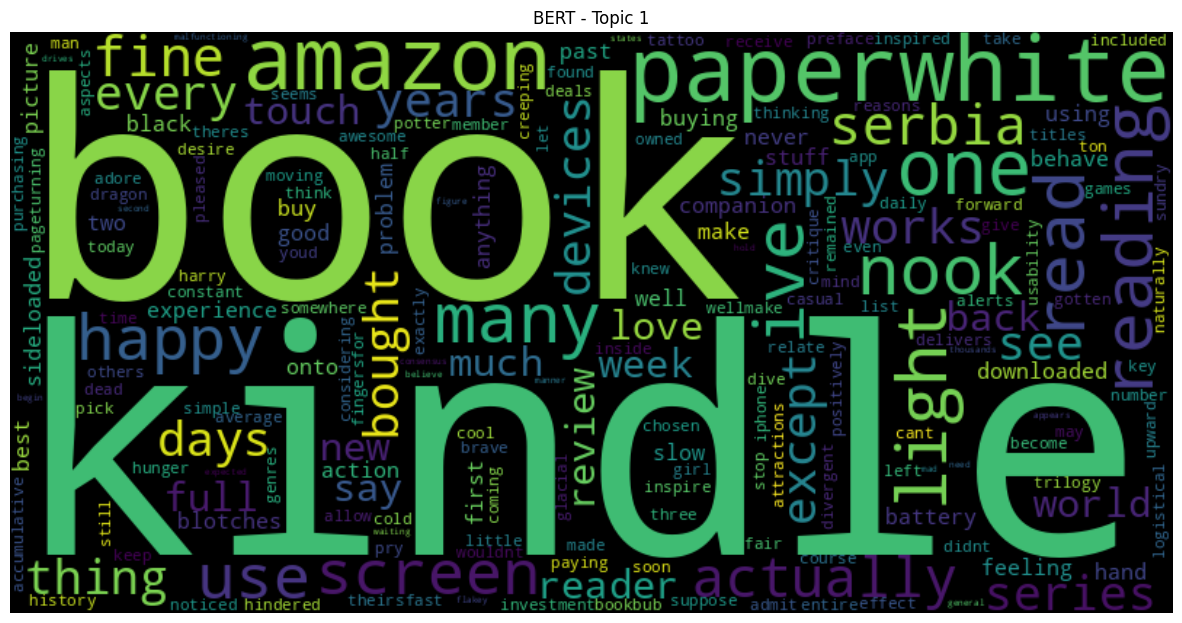

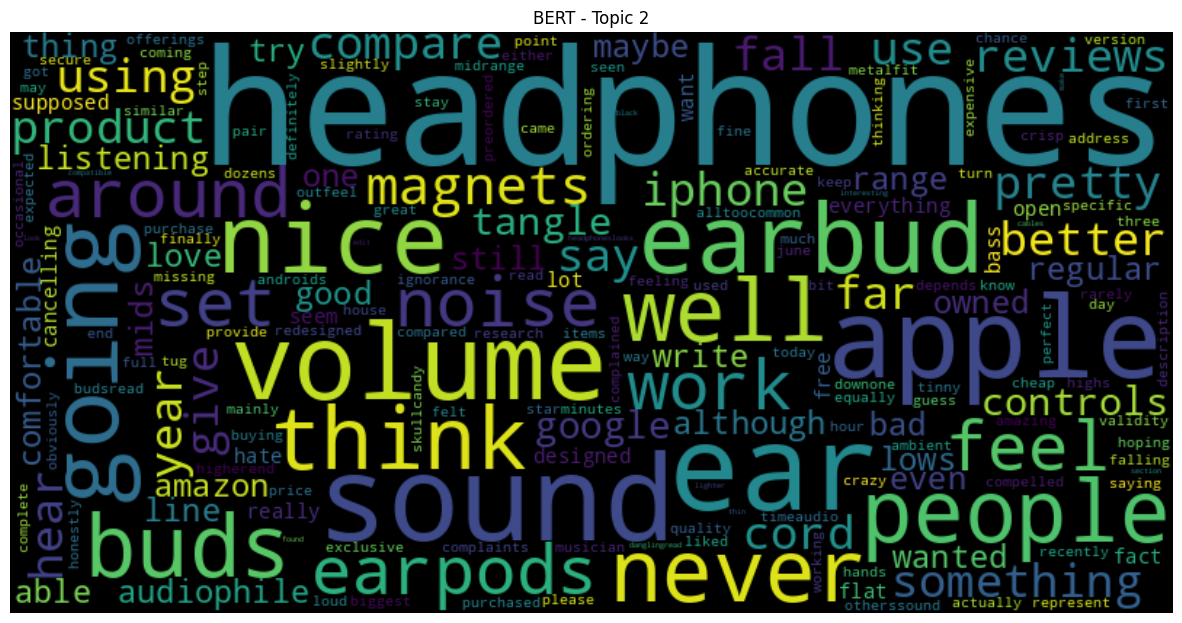

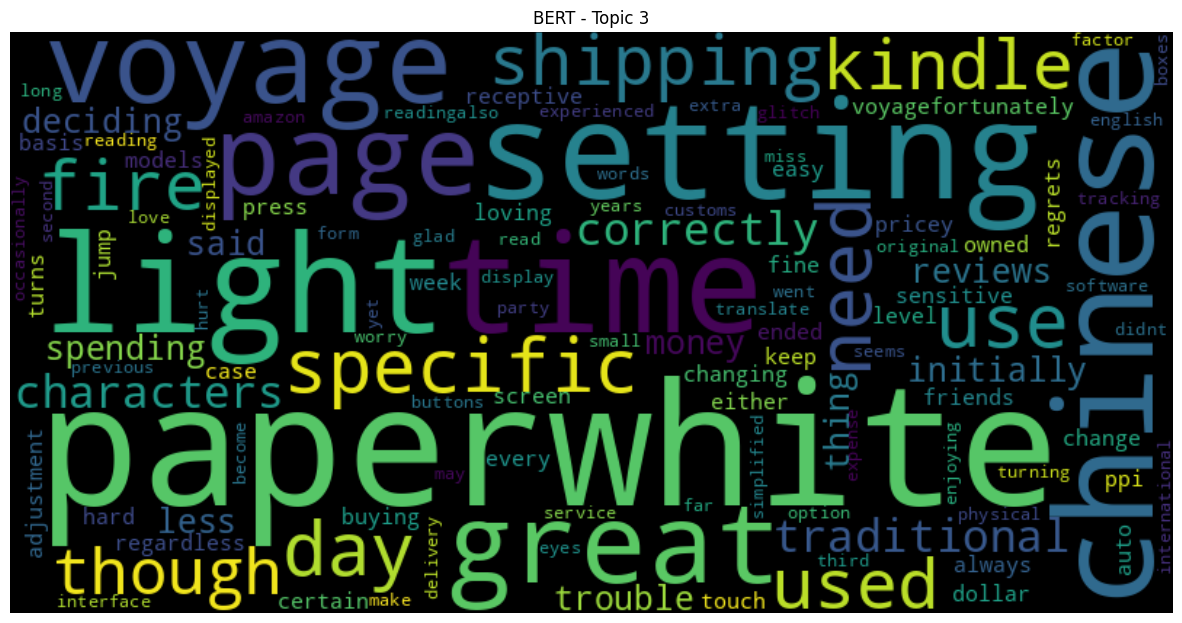

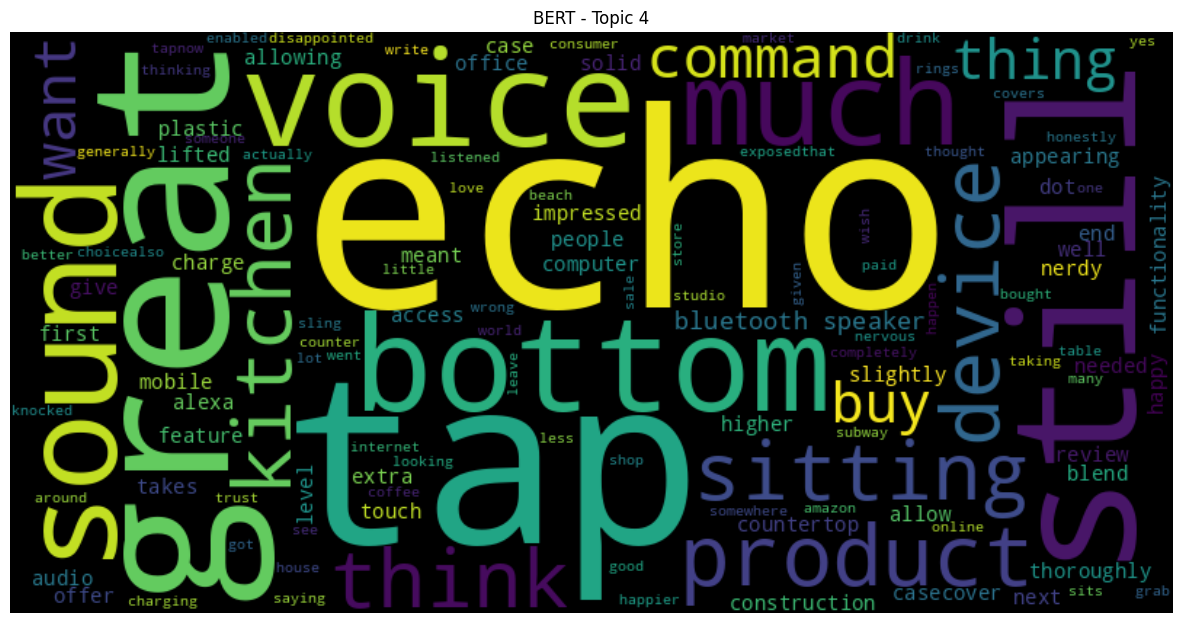

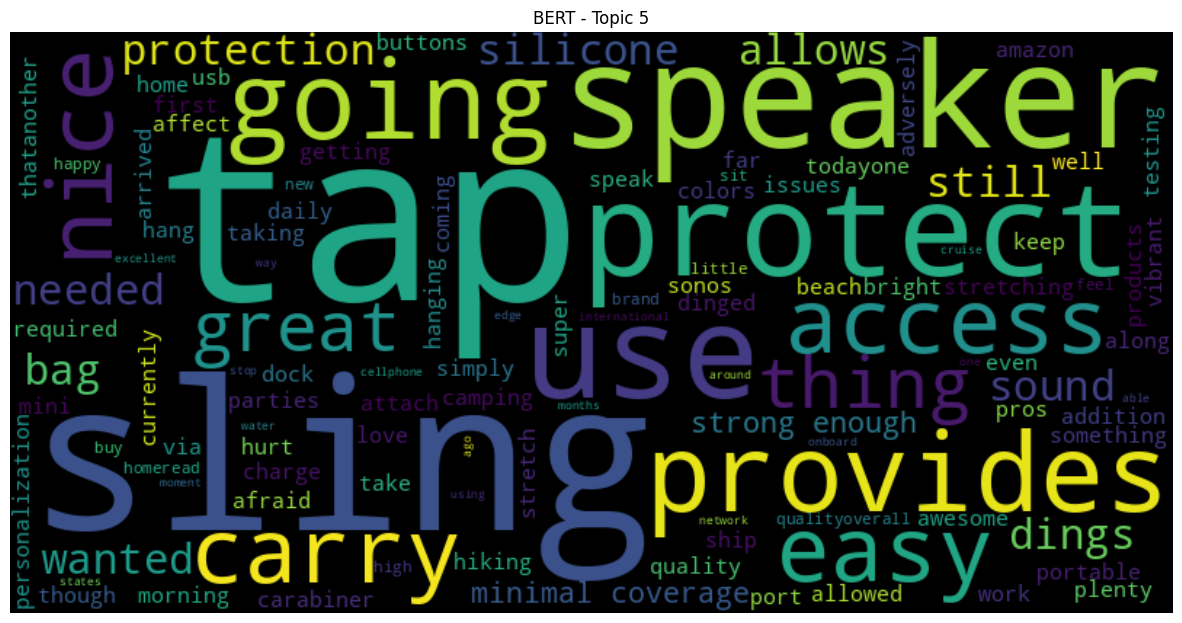

In [ ]:
for i, (topic, words) in enumerate(bert_topics.items(), 1):
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(words)
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"BERT - {topic}")
    plt.axis('off')
    plt.show()